# Time series modeling: classical and Bayesian approaches

The previous chapter was focused on analyzing the cross section of stock returns, which provides answers to questions such as why does a given stock have higher/lower returns than another stock, for example. This is done by breaking down returns of stocks (or portfolios) into risk factors, and regressing the returns on the factors with the use of linear models. This results in the investing approach known as factor investing.

Another fundamental aspect of asset returns is how returns for a same asset relate to each other over time. The collection of asset returns along time consists a financial time series. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import seaborn as sns
import yfinance as yf
import pymc as pm
import arviz as az
%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Time series data consists of data observed that is indexed along time. The time interval between points are generally a time unit, such as a day, month, year and so on. It differs from cross sectional data in that cross section analysis usually seeks to study the relation between different variables, and time series looks at values of a variable as functions of past observed values.

Cross sections can also have observations indexed along time, but crucial to it is the assumption that the different observations are independent of each other. Time series models can allow for dependence on past observed values, in this context known as autocorrelation.

In a similar way to the statistical correlation between two different variables, the statistical correlation between the current and past observed values along time for the same variable is known as autocorrelation. The formula for both is also similar, although the obtention of time series autocorrelation depends on the assumption of weak stationarity.

Stationarity, on its weak form, mean that both the mean and variance for the random variable is time invariant, i.e., does not change over time. Therefore, in a (weakly) stationary time series, the mean is a constant and the covariance between two points depends on a constant variance and the distance between those two points, so that the covariance is scaled to the distance between the two points.

In classical statistics, for any time series we can use statistical tests to verify the stationarity hypothesis, after obtaining the autocorrelation function (ACF). An example of such statistical test is the Ljung-Box test.

Let's try to obtain the ACF for a time series and perform the Ljung-Box test

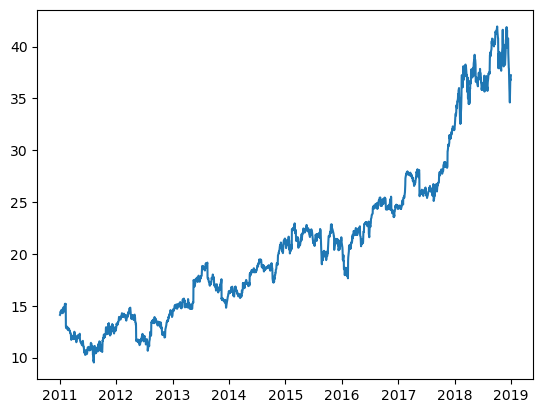

In [4]:
start_date = "2011-01-01"
end_date = "2019-01-01"

csco = yf.Ticker("CSCO").history(start = start_date, end = end_date)["Close"]
csco.index = csco.index.tz_localize(None)
plt.plot(csco)

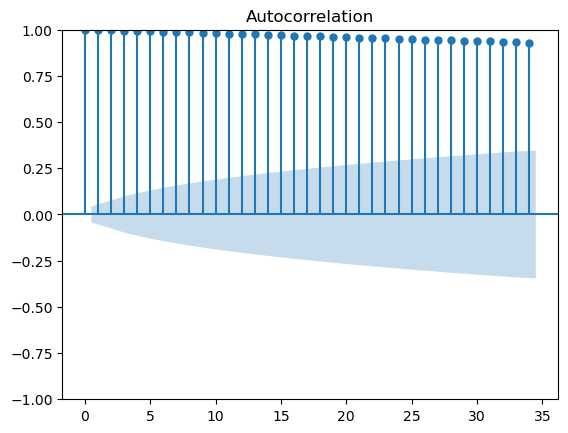

In [5]:
sm.graphics.tsa.plot_acf(csco.values)
plt.show()

In [6]:
### Calculate the Ljung-Box test statistics (Q) for each lag

acf_values = sm.tsa.stattools.acf(csco.values)

lb_test = sm.tsa.stattools.q_stat(acf_values, len(csco))
print("Q statistics for successive lags: " + str(lb_test[0].round(0)))
print("p-values for successive lags: " + str(lb_test[1].round(0)))

Q statistics for successive lags: [ 2015.  4023.  6024.  8018. 10006. 11988. 13964. 15933. 17896. 19851.
 21800. 23741. 25674. 27599. 29516. 31426. 33329. 35224. 37112. 38991.
 40862. 42725. 44581. 46430. 48272. 50108. 51937. 53760. 55576. 57384.
 59185. 60980. 62768. 64550.]
p-values for successive lags: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The test indicates a very high and persistent autocorrelation

A particular type of time series known as white noise consists of identically and independent distributed (IID) random variables, with finite mean and variance. Furthermore, when these random variables follow a normal distribution, they are called Gaussian white noise. As they are independently distributed, the computed ACF for a white noise process should have all of its values near zero. 

## ARIMA and the Box-Jenkins approach

In the case a time series has persistent autocorrelation, this means that past realized values might prove useful in predicting future values. A type of model that takes this into account is the autoregressive model, or AR, usually denoted as AR(p), where p is the number of lags included in the model.

An AR(1) model can be written as

$y_t = \alpha + \phi y_{t-1} + \varepsilon_t$,

where $\varepsilon_t$ is a white noise process with mean zero and finite variance $\sigma^2$. As the process is stationary, it will have a constant mean $\mu = \frac{\alpha}{1-\phi}$, however the stationarity condition $-1 < \phi < 1$ must always be verified.

Another type of useful model for data with autocorrelation is the moving average (MA) model. Unlike the AR model, for the MA the value of the observation $y_t$ is not a function of the past values of itself, but of the past random shocks. Moving average models are usually denoted as MA(q), with q being the number of lags for the past random shocks.

A MA(1) model has the form

$y_t = \alpha + \varepsilon_t - \theta \varepsilon_{t-1}$,

where $\varepsilon_t$ are the white noise random shocks with mean zero and finite variance. Moving average models are always stationary. 

There is an uncanny relationship between AR and MA models where a MA(1) can be written as an AR(∞) model, and an AR(1) can also be written as a MA(∞). Let's start with a particular type of AR(∞) model

$y_t = - \theta y_{t-1} - \theta^2 y_{t-2} - \theta^3 y_{t-3} - \dots + \varepsilon_t$,

where the AR coefficient for lag $p$ is $\theta^p$, with $|\theta| <1$ and $\alpha = 0$. Introducing the lag operator $L$ so that $L^p y_t = y_{t-p}$, we can verify that

$y_t + \theta y_{t-1} + \theta^2 y_{t-2} + \theta^3 y_{t-3} + \dots = y_t + \theta L y_t + \theta^2 L^2 y_t + \theta^3 L^3 y_t + \dots = \frac{y_t}{1-\theta L} = \varepsilon_t$,

$y_t = (1-\theta L) \varepsilon_t = \varepsilon_t - \theta \varepsilon_{t-1}$, 

which is the MA(1) model. Doing the same for the MA(∞) model

$y_t = \theta \varepsilon_{t-1} + \theta^2 \varepsilon_{t-2} + \theta^3 \varepsilon_{t-3} + \dots + \varepsilon_{t}$ 

$= \varepsilon_t + \theta L \varepsilon_t + \theta^2 L^2 \varepsilon_{t} + \theta^3 L^3 \varepsilon_{t} + \dots = \frac{\varepsilon_t}{1- \theta L}$

$= \theta y_{t-1} + \varepsilon_t$,

which is the AR(1) model.

Both AR and MA models can be combined in another type of model, ARMA. Usually denoted as ARMA(p,q), it has both p autoregressive terms and q moving average terms. An ARMA(1,1) model looks like

$y_t = \alpha + \phi y_{t-1} + \varepsilon_t - \theta \varepsilon_{t-1}$,

where we can note both the autoregressive and moving average terms.

Let's simulate the three types of processes and see what they look like

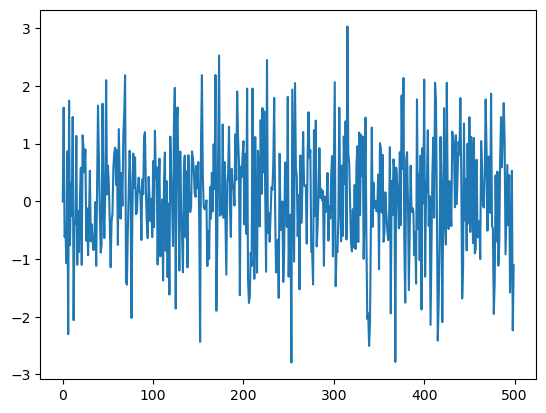

In [7]:
np.random.seed(1)

### Simulating whine noise process with mean zero and variance 1

wn = np.empty(500)
wn[0] = 0
for i in range(0, len(wn)-1):
    wn[i+1] = np.random.randn()
plt.plot(wn)

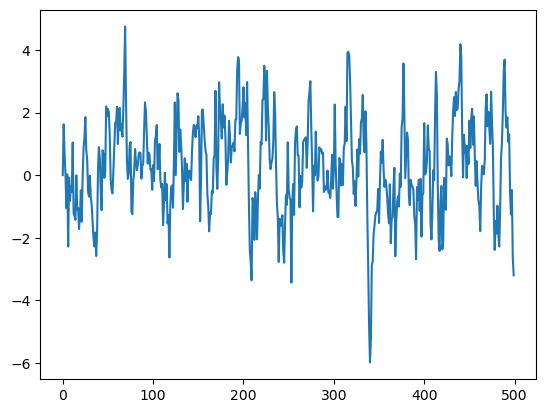

In [8]:
np.random.seed(1)

### Simulating AR(1) process with mean zero and variance 1

phi = 0.8

ar = np.empty(500)
ar[0] = 0
for i in range(0, len(ar)-1):
    ar[i+1] = (phi * ar[i]) + np.random.randn()
plt.plot(ar)

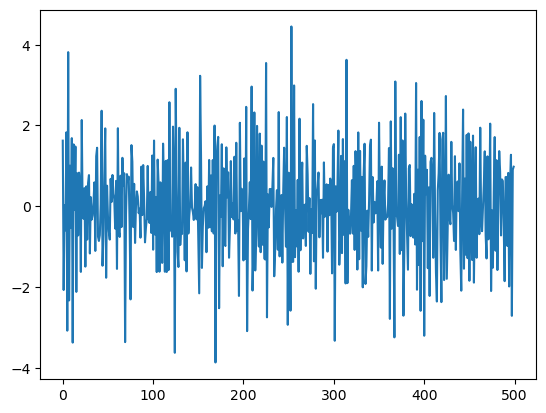

In [9]:
np.random.seed(1)

### Simulating MA(1) process with mean zero and variance 1

theta = 0.9

ma = np.empty(500)
ma[0] = np.random.randn()
shock_past = ma[0]
for i in range(0, len(ma)-1):
    shock_current = np.random.randn()
    ma[i+1] = shock_current - (theta * shock_past)
    shock_past = shock_current
plt.plot(ma)

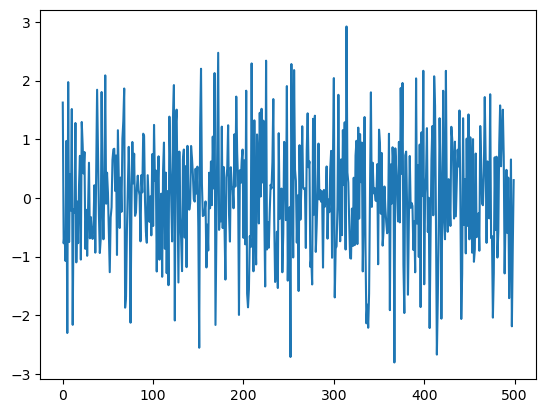

In [10]:
np.random.seed(1)

### Simulating ARMA(1,1) process with mean zero and variance 1

phi = 0.8
theta = 0.9

arma = np.empty(500)
arma[0] = np.random.randn()
shock_past = arma[0]
for i in range(0, len(arma)-1):
    shock_current = np.random.randn()
    arma[i+1] = (phi * arma[i]) + shock_current - (theta * shock_past)
    shock_past = shock_current
plt.plot(arma)

At first glance, all three processes are similar. Depending on the AR and MA parameter values, it can be practically impossible to distinguish the process types from eyeballing only. 

How do we know which model is the right one for our data, then? That will depend on the autocorrelation structure of our data. The already mentioned ACF, which is the measure of correlation between a series and past values of itself. Closely related is the partial ACF (PACF), which is similar to the ACF but removes the effects of intermediate correlations. For example, the ACF between observations $y_t$ and $y_{t-k}$ includes the effects of all intermediate lags $t-1, t-2, \ldots, t-k+1$ while the PACF between the same observations removes the effects of the intermediate lags.

The ACF and PACF are useful for identifying lags of MA and AR models, respectively. A strong ACF (PACF) spike at lag $k$ and PACF (ACF) with slow decay indicates the presence of a MA (AR) structure with $k$ lags. If both ACF and PACF have slow decay, this can show the presence of an ARMA structure, although the order of the ARMA model cannot be identified via ACF and PACF.

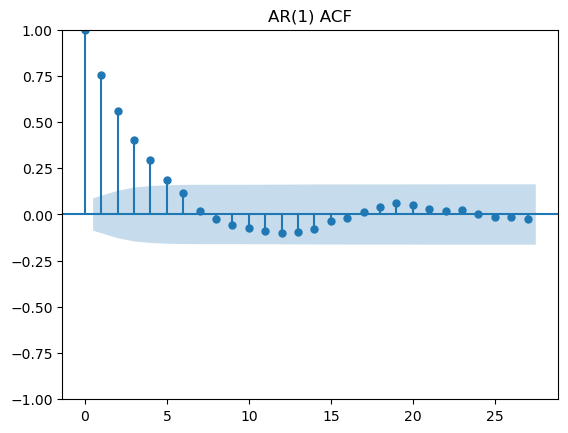

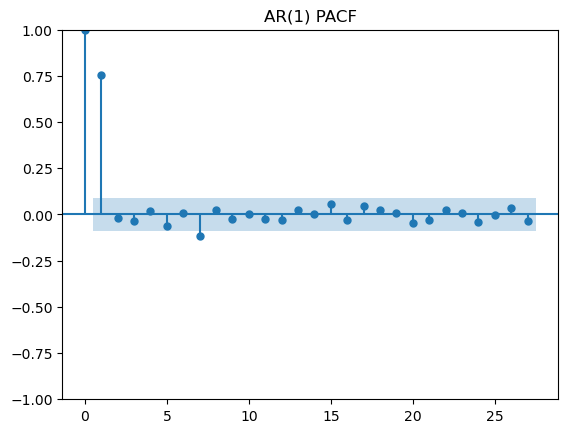

In [11]:
# ACF and PACF for AR(1) process
# We should see a strong spike at lag 1 of the PACF and slowly decaying ACF

sm.graphics.tsa.plot_acf(ar)
plt.title("AR(1) ACF")

sm.graphics.tsa.plot_pacf(ar)
plt.title("AR(1) PACF")
plt.show()

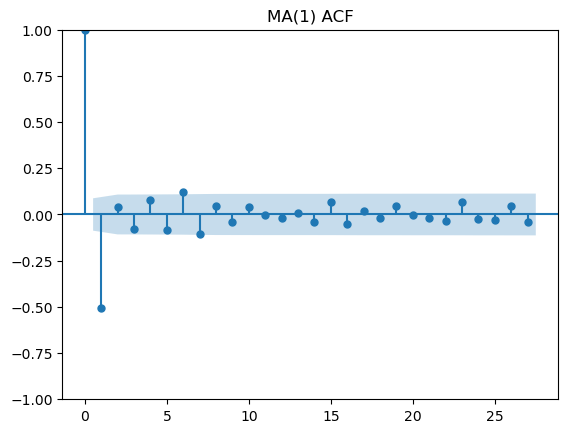

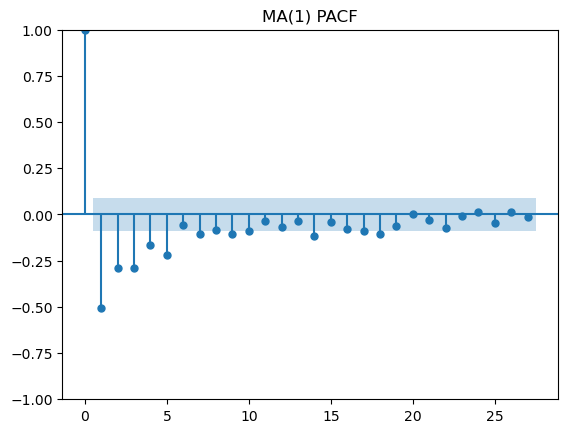

In [12]:
# ACF and PACF for MA(1) process
# We should see a strong spike at lag 1 of the ACF and slowly decaying PACF

sm.graphics.tsa.plot_acf(ma)
plt.title("MA(1) ACF")

sm.graphics.tsa.plot_pacf(ma)
plt.title("MA(1) PACF")
plt.show()

The AR, MA and ARMA models require that the time series be stationary. The presence of nonstationarity brings some issues that we must be aware of, such as spurious correlations.

Let's try an experiment. We shall generate two time series that we know to be completely independent of each other:

$x_t = \alpha + x_{t-1} + \varepsilon_t$,

$y_t = \beta + y_{t-1} + u_t$,

$\varepsilon_t \sim N(0,\sigma^2)$, $u_t \sim N(0, \xi^2)$. In this case we know that $x_t$ and $y_t$ are completely independent of each other because $x_t$ does not enter the equation for the definition of $y_t$ and vice versa.

However, if we treat both time series as a cross section and estimate a linear regression model, we can observe a very high correlation.

This is a case where correlation does not imply causality, as the statistical correlation is very high but, as in this case we know the data generating processes behind $x_t$ and $y_t$, the causality is absent as the two processes are completely independent of each other.

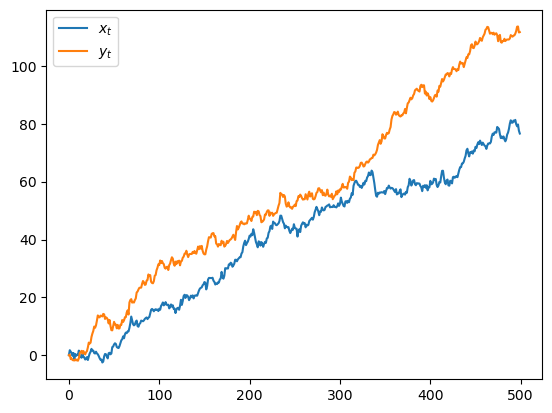

In [13]:
np.random.seed(1)

### Simulating both series with constant mean and variance 1

alpha = 0.1
beta = 0.2

x_t = np.empty(500)
x_t[0] = 0
for i in range(0, len(x_t)-1):
    x_t[i+1] = alpha + x_t[i] + np.random.randn()
y_t = np.empty(500)
y_t[0] = 0
for i in range(0, len(y_t)-1):
    y_t[i+1] = beta + y_t[i] + np.random.randn()

plt.plot(x_t, label=r"$x_t$")
plt.plot(y_t, label=r"$y_t$")
plt.legend()

In [14]:
# Treat series as cross section and estimate OLS

ols_model = sm.OLS(y_t, sm.add_constant(x_t)) # add_constant so that our model has an intercept
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     5817.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          7.85e-277
Time:                        19:27:51   Log-Likelihood:                -1812.7
No. Observations:                 500   AIC:                             3629.
Df Residuals:                     498   BIC:                             3638.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6854      0.804      4.585      0.0

We observe a very high t-stat (and low p-value) for the regression coefficient.

When we have real data, we do not know the equations for the true data generating processes, however this example illustrates how both series having a trend will lead to high statistical (and possibly spurious) correlations between them.

In our example, both $x_t$ and $y_t$ are random walks with drifts. A random walk is one of the simplest examples of nonstationary time series. A random walk has the mathematical form

$y_t = y_{t-1} + \varepsilon_t$,

with $\varepsilon_t$ being Gaussian white noite. The RW can also be imagined as an AR(1) with $\phi = 1$. Remember: in order for the AR(1) to be stationary, the coefficient needs to be out of the unit circle, i.e., $|\phi| < 1$. If $\phi = 1$, the series is a random walk and if $|\phi| > 1$ the series is explosive.

The RW does not converge neither explode, but rather has a distinct behavior that can be visualized through two of its characteristics: the Markov and martingale properties. 

The Markov property states that, in order to make predictions for a process $y_{t+s}$, with $s = 1,2,\ldots,\infty$, the only useful information is contained in the present value $y_t$, and therefore the past values such as $y_{t-1}$ or $y_{t-2}$ are useless for future predictions at instant $t$. In other words, a Markov process is memoryless.

The martingale property means that the expected value $E[y_{t+1}]$ given $y_t$ is equal to $y_t$. This is also known as the fair game property, because all expected future gains of a martingale lottery would be equal to the present gains. 

The Markov and martingale properties are not equivalent to each other. A Markov process may not be a martingale, and vice versa. A random walk is both.

A RW with drift is similar, except it has the presence of a constant drift term:

$y_t = \mu + y_{t-1} + \varepsilon_t$,

with $\varepsilon_t$ also being Gaussian white noise. We say that both types of random walk have a stochastic trend due to the effect of the past observed values on subsequent values, e.g., the effect of $y_{t-1}$ on $y_t$.

Time series can also show a deterministic trend, such as the model

$y_t = \mu t + \varepsilon_t$.

The difference between both types of trend is that, for the stochastic trend models, the variance increases with the time window ($Var(y_t) = \sigma^2 t)$) while for the deterministic trend model it is constant ($Var(y_t) = \sigma^2)$.

We say series are trend stationary if after removing a deterministic trend, it becomes stationary. On the other hand, a series is said to be difference stationary if it becomes stationary after differencing, i.e., calculating its first difference. The first difference for a given value is the observed value minus the previous value.

In empirical applications, series are considered to be trend stationary if a fitted deterministic trend shows white noise residuals. Conversely, the series is considered difference stationary if a fitted stochastic trend shows white noise residuals.

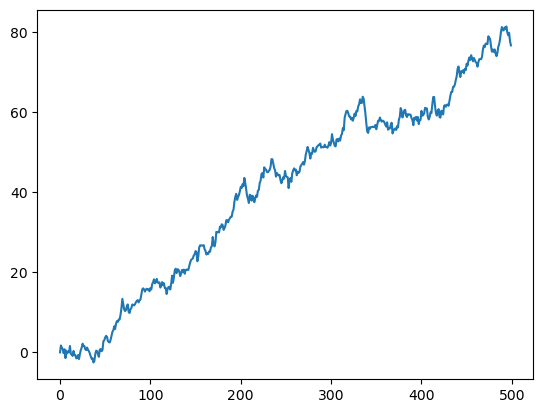

In [15]:
np.random.seed(1)

### Simulating process with stochastic trend

mu = 0.1

s_trend = np.empty(500)
s_trend[0] = 0
for i in range(0, len(s_trend)-1):
    s_trend[i+1] = mu + s_trend[i] + np.random.randn()
    
plt.plot(s_trend)

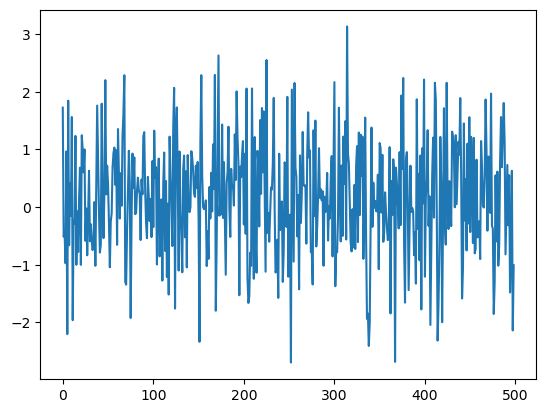

In [16]:
# Differencing process with stochastic trend
# It should look like white noise

s_diff = np.diff(s_trend)
plt.plot(s_diff)

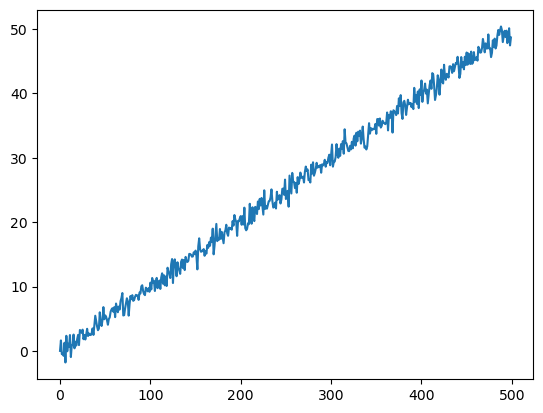

In [17]:
np.random.seed(1)

### Simulating process with deterministic trend

mu = 0.1

d_trend = np.empty(500)
d_trend[0] = 0
for i in range(0, len(d_trend)-1):
    d_trend[i+1] = (mu * i) + np.random.randn()
plt.plot(d_trend)

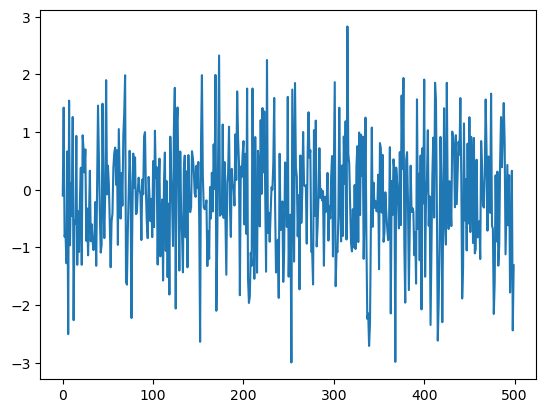

In [18]:
# Removing deterministic trend from the deterministic trend process
# It should look like white noise

d_detrend = d_trend - (mu * np.arange(1, 501))
plt.plot(d_detrend)

A very important source of nonstationarity in time series are unit roots, such as in random walk models. Random walks, with or without drift, are unit root processes. Unit root processes are named like that because the characteristic equation for such processes has a root that lies in the unit circle. If a process has one autoregressive component, the coefficient for that component equals 1.

Unit roots introduce stochastic trends into time series, which makes standard estimates invalid because of spurious correlations. The stochastic trend can be removed by differencing, turning a nonstationary series into a stationary one. For example, say we have the random walk

$y_t = y_{t-1} + \varepsilon_t$.

The first difference

$\Delta y_t = y_t - y_{t-1}$

is stationary, in this case white noise because $\Delta y_t = \varepsilon_t$. 

The amount of times a series has to be differenced to become stationary is known as the order of integration, denoted as I(d). Most nonstationary series, such as random walks, are I(1), meaning they need to be differenced only once in order to become stationary. Orders of integration of 2 and above are rare in practise. I(0) means a series is stationary.

Empirical time series can be checked for unit roots via statistical unit root tests. Examples of such tests are the ADF and KPSS tests.

In [19]:
# ADF test with constant and drift
print("ADF test p-value: "  + str(sm.tsa.stattools.adfuller(csco, regression="c")[1]))

# KPSS test with constant and trend
print("KPSS test p-value: < "  + str(sm.tsa.stattools.kpss(csco, regression="ct")[1]))

ADF test p-value: 0.9866451935458107
KPSS test p-value: < 0.01


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_24348\2059465322.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print("KPSS test p-value: < "  + str(sm.tsa.stattools.kpss(csco, regression="ct")[1]))


Nonstationary time series can be modelled in a fashion similar to the ARMA approach with autoregressive integrated moving average (ARIMA) models. An ARIMA time series, denoted as ARIMA(p,d,q), is an I(d) time series whose d-th difference follows an ARMA(p,q) process. For example, a proces is ARIMA(1,1,1) if its first difference follows an ARMA(p,q) process.

Seasonality might also appear in time series, and can be dealt with through seasonal adjustments. One of the simplest types of seasonal adjustment is called seasonal differencing. For example, if a monthly time series $y_t$ has a seasonal period of 12, the seasonal difference is $y_t - y_{t-12}$.

Seasonal ARIMA (SARIMA) models can be specified by combining the ARIMA approach with seasonal adjustments. SARIMA models, denoted as SARIMA(p,d,q)(P,D,Q)$_m$, where (p,d,q) and (P,D,Q) are the ARIMA elements of the nonseasonal and seasonal components of the series, and $m$ stands for the seasonal period.

Exogenous regressors can also be specified for SARIMA models, resulting in the SARIMA with exogenous regressors (SARIMAX) models.

The Python library statsmodels can implement SARIMAX models with ease: https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html

Statsmodels also has a built-in function to simulate ARMA processes. Let's try to simulate and ARMA(1,1) process, obtain the corresponding ARIMA(1,1,1) and see what it looks like.

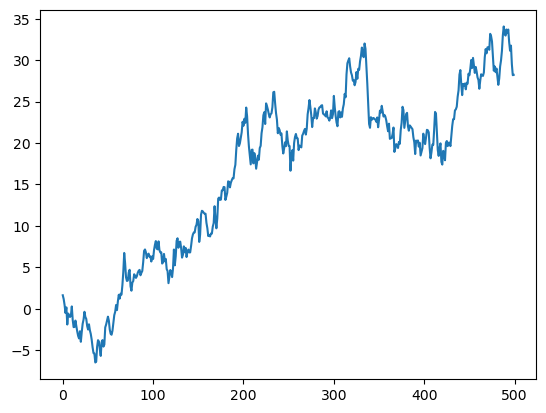

In [20]:
np.random.seed(1)

### Simulate ARMA(1,1) process and calculate cumulative sum to obtain ARIMA(1,1,1)

phi = 0.8
theta = 0.9

arma_sample = sm.tsa.arma_generate_sample(ar = (1, phi), ma = (1, theta), nsample=500)
arima_sample = np.cumsum(arma_sample)

plt.plot(arima_sample)

The empirical procedure for fitting ARMA and ARIMA models is summarized in the Box-Jenkins approach:

1. Analyze the time series data for the presence of (non)stationarity and/or seasonality. This is conceptually akin to exploratory data analysis, and is carried out through the use of ACF and PACF functions. This step determines the order for all of the possible SARIMA elements.

2. Estimate the proposed model with statistical and computational methods. 

3. Perform model diagnostics to make sure the residuals of the model follow a white noise process, and do not present autocorrelation. Both statistical tests, e.g. Ljung-Box test, and ACF/PACF plots are useful in this.

([], [])

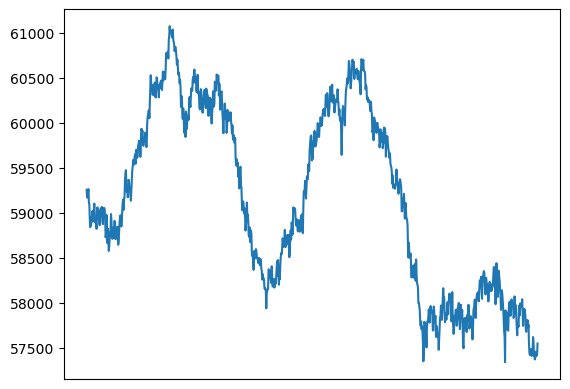

In [21]:
shelter_data = pd.read_csv("https://data.cityofnewyork.us/api/views/k46n-sa2m/rows.csv?accessType=DOWNLOAD", index_col=0)["Total Individuals in Shelter"][1800:2800]
shelter_data.index = pd.DatetimeIndex(shelter_data.index).to_period("D")
plt.plot(shelter_data.values)
plt.xticks([], [])

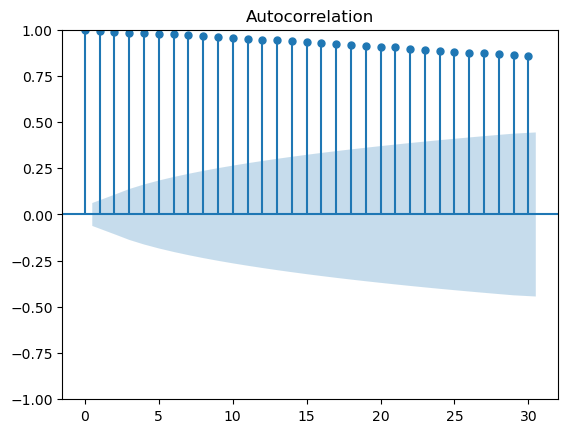

In [22]:
sm.graphics.tsa.plot_acf(shelter_data.values)
plt.show()

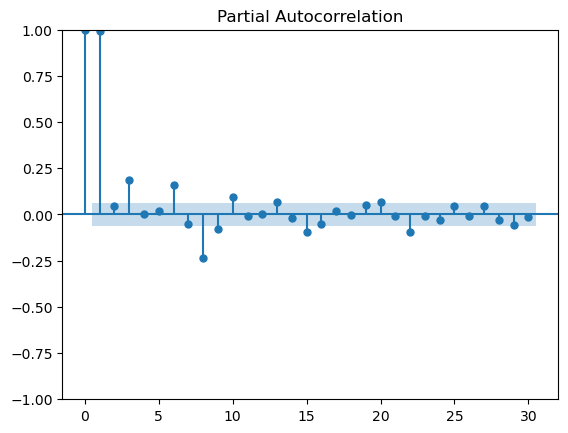

In [23]:
sm.graphics.tsa.plot_pacf(shelter_data.values)
plt.show()

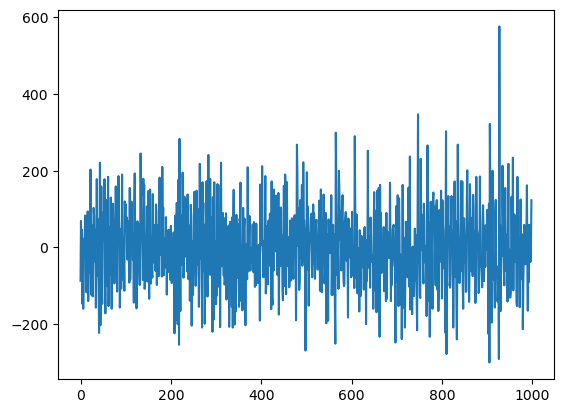

In [24]:
shelter_diff = np.diff(shelter_data.values)
plt.plot(shelter_diff)

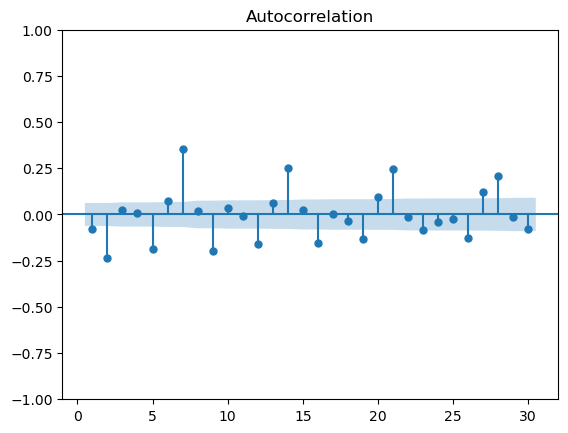

In [25]:
sm.graphics.tsa.plot_acf(shelter_diff, zero=False)
plt.show()

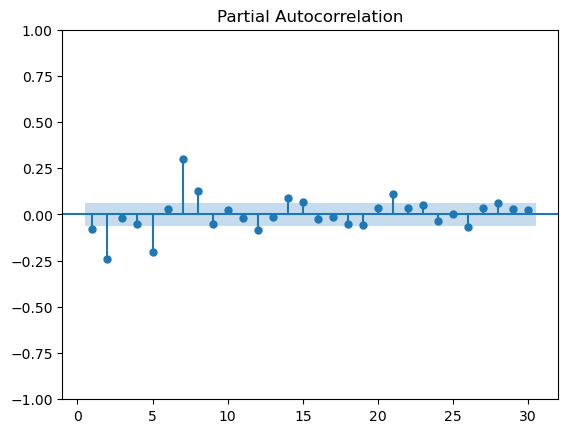

In [26]:
sm.graphics.tsa.plot_pacf(shelter_diff, zero=False)
plt.show()

In this case, the series is I(1) and its first difference shows white noise behavior. A random walk, or ARIMA(0,1,0) model would seem appropriate

Let's try to fit one with the statsmodels package

In [27]:
model = sm.tsa.arima.ARIMA(shelter_data.values, order=(0, 1, 0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6050.849
Date:                Mon, 01 Jan 2024   AIC                          12103.699
Time:                        19:27:59   BIC                          12108.606
Sample:                             0   HQIC                         12105.564
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.067e+04    395.336     26.983      0.000    9892.415    1.14e+04
Ljung-Box (L1) (Q):                   5.86   Jarque-Bera (JB):                50.44
Prob(Q):                              0.02   Pr

([], [])

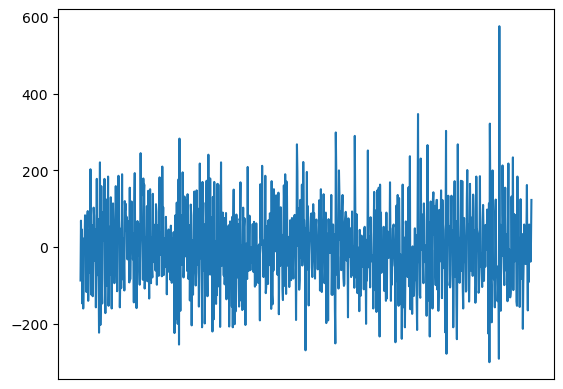

In [28]:
plt.plot(results.resid[1:])
plt.xticks([], [])

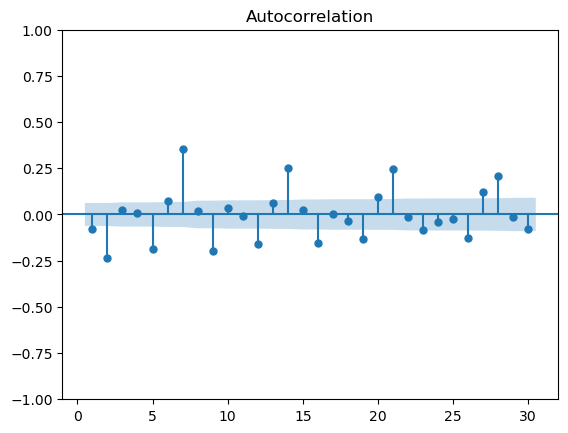

In [29]:
sm.graphics.tsa.plot_acf(results.resid[1:], zero=False)
plt.show()

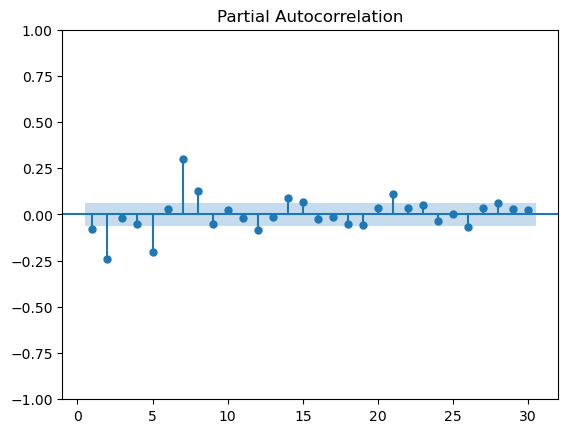

In [30]:
sm.graphics.tsa.plot_pacf(results.resid[1:], zero=False)
plt.show()

The residuals for the model show white noise behavior

## Vector autoregressions for multivariate time series

In the case we want to model multiple time series and cannot assume exogeneity, we need to make use of statistical models where the series are endogenous to each other, i.e. the realized values of one series influences the future values of other series.

The most famous of such models is the vector autoregression, or VAR. The VAR assumes endogeneity between variables, which means the past values for one variable determines present values of the other variable. For a bivariate VAR(1), this would look like

$x_t = \phi_{11} x_{t-1} + \phi_{12} y_{t-1} + \varepsilon_{1t}$,

$y_t = \phi_{21} x_{t-1} + \phi_{22} y_{t-1} + \varepsilon_{2t}$,

assuming no constant terms for either process. It is also common to use matrix notation for VAR models, as, in higher dimensional settings, this makes notation much easier to read. The same VAR in matrix notation could be expressed as

$\textbf{y}_t = A \textbf{y}_{t-1} + \boldsymbol{\varepsilon}_t$, 

$\textbf{y}_t = \begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}$, $A = \begin{bmatrix} \phi_{11} & \phi_{12} \\ \phi_{21} & \phi_{22} \end{bmatrix}$, $\boldsymbol{\varepsilon}_t \sim N(\textbf{0}, \Sigma_\varepsilon)$,

where $\Sigma_\varepsilon$ is the covariance matrix of the errors.

Just like the univariate AR, a VAR needs to satisfy stationarity conditions. In the matrix notation, the stationarity condition for a bivariate VAR(1) process can be expressed as

$|A - \Lambda I_p| = 0$, 

where $I_p$ is an identity matrix of order $p$ (in our case $p = 2$ because the VAR is bivariate) and $\Lambda$ is the diagonal matrix of the $p$ eigenvalues obtained from the spectral decomposition $A = \textbf{V} \Lambda \textbf{V}^{-1}$, where $\textbf{V}$ is the matrix composed of the $p$ eigenvectors. A VAR, just like the AR process, can also be represented as a (vector) moving average.

One of the main functions of VAR models is forecasting of one variable in function of the others. Forecasts in the VAR framework are generated recursively, meaning we obtain forecasts of future variables plugging in the past observed values plus the estimated parameters. The error covariance can also be used to generate prediction intervals and forecast error measures such as MSE.

Besides generating predictions for out-of-sample observations, we can also check how our model explains the data in our sample. This is known as structural analysis, and we present 3 ways for it: variance decomposition, impulse-response functions and Granger causality. 

So far, the type of VAR model we have been analyzing is the reduced-form VAR, as each equation only has one variable at time $t$, disregarding the simultaneous effect one variable can have on another. Actually, this simultaneity is present in the errors, which cannot be interpreted as exogenous shocks to each variable, as both exogenous shocks to each variable ate tied together in the reduced-form errors. In order to have causal interpretations about the model shocks, we need a structural-form VAR (SVAR), which in turn requires identification restrictions. Structural analysis is best employed when analyzing a structural VAR, but here we perform structural analysis for the reduced-form VAR.

The variance decomposition procedure consists of decomposing the forecasting error variance so that we can see how much of it is explained by shocks in each of the variables, attributing a corresponding percentage. Once again, the causal intepretation is limited as we are looking at the reduced-form VAR.

Impulse-response functions (IRF) are obtained so we can visualize the impact of a shock to one variable to each of the variables along time. Remembering that, as we are using the reduced-form VAR, these shocks, and therefore the IRFs, do not have a causal interpretation. The IRF relies on the vector moving average representation of the VAR, as a VAR(1) model can be written as a vector moving average of order infinity, and a VAR of any order $p$ can be rewritten to be represented as a VAR(1) using a companion form. If the stationarity conditions are met, the response to the shocks will dissipate over time, becoming closer to zero.

Granger causality is a type of statistical test that allows us to test if each variable is useful in determining the others within our sample. Besides what the name suggests, it is hard to draw causal interpretations solely out of Granger causality tests because the out-of-sample extrapolation is limited and also we are using the reduced-form VAR.

We can estimate a VAR, perform structural analysis and generate forecasts with the statsmodels library

In [33]:
start_date = "2017-01-01"
end_date = "2022-06-01"

cvx = yf.Ticker("CVX").history(start = start_date, end = end_date)["Close"].rename("CVX").interpolate()
wti = yf.Ticker("CRUD.L").history(start = start_date, end = end_date)["Close"].rename("WTI")
icln = yf.Ticker("ICLN").history(start = start_date, end = end_date)["Close"].rename("ICLN")
cvx.index = cvx.index.tz_localize(None)
wti.index = wti.index.tz_localize(None)
icln.index = icln.index.tz_localize(None)
cvx_diff = np.log(cvx).diff().dropna()
wti_diff = np.log(wti).diff().dropna()
icln_diff = np.log(icln).diff().dropna()

var_data = pd.DataFrame([cvx_diff,wti_diff,icln_diff]).T.dropna()
var_data

,CVX,WTI,ICLN
Date,,,
2017-01-04,-0.000254,-0.009780,0.017413
2017-01-05,-0.004338,0.003679,0.006146
2017-01-06,-0.004015,0.016991,-0.004914
2017-01-09,-0.008596,-0.026831,0.003688
2017-01-10,-0.007626,-0.017457,0.001226
...,...,...,...
2022-05-24,0.005343,-0.002756,-0.014698
2022-05-25,0.015918,0.003673,0.014177
2022-05-26,0.006705,0.033795,0.024718


In [34]:
model = sm.tsa.VAR(var_data)
results = model.fit(1)
results.summary()

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Jan, 2024
Time:                     19:29:29
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.5774
Nobs:                     1336.00    HQIC:                  -23.6066
Log likelihood:           10105.8    FPE:                5.49767e-11
AIC:                     -23.6241    Det(Omega_mle):     5.44858e-11
--------------------------------------------------------------------
Results for equation CVX
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000411         0.000570            0.721           0.471
L1.CVX         -0.117852         0.034871           -3.380           0.001
L1.WTI         -0.019873         0.024910           -0.798           0.425
L1.ICLN    

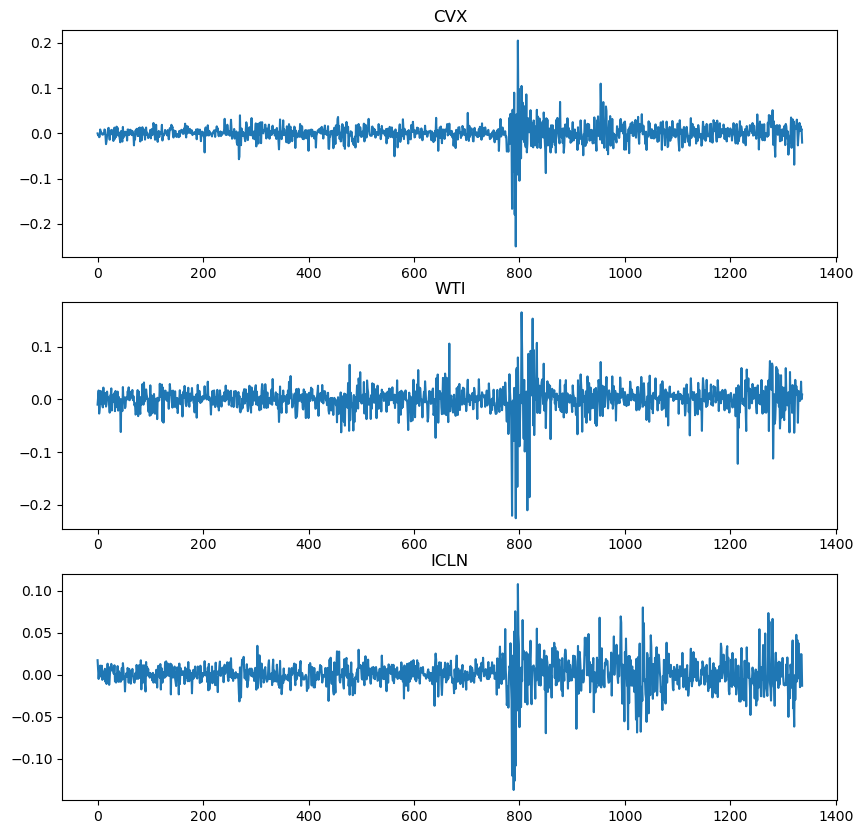

In [35]:
results.plot()
plt.show()

In [36]:
results.forecast(var_data.values[-1:], 10)

array([[ 2.95569678e-03, -8.10675648e-04,  2.58946901e-03],
       [ 1.69949905e-05,  3.21294046e-04,  4.62377879e-04],
       [ 3.91277117e-04,  1.80824337e-04,  7.16859693e-04],
       [ 3.43923499e-04,  1.98836597e-04,  6.83420738e-04],
       [ 3.49939295e-04,  1.96566898e-04,  6.87573479e-04],
       [ 3.49176941e-04,  1.96855945e-04,  6.87039937e-04],
       [ 3.49273695e-04,  1.96819369e-04,  6.87107094e-04],
       [ 3.49261427e-04,  1.96824015e-04,  6.87098536e-04],
       [ 3.49262983e-04,  1.96823426e-04,  6.87099618e-04],
       [ 3.49262786e-04,  1.96823501e-04,  6.87099481e-04]])

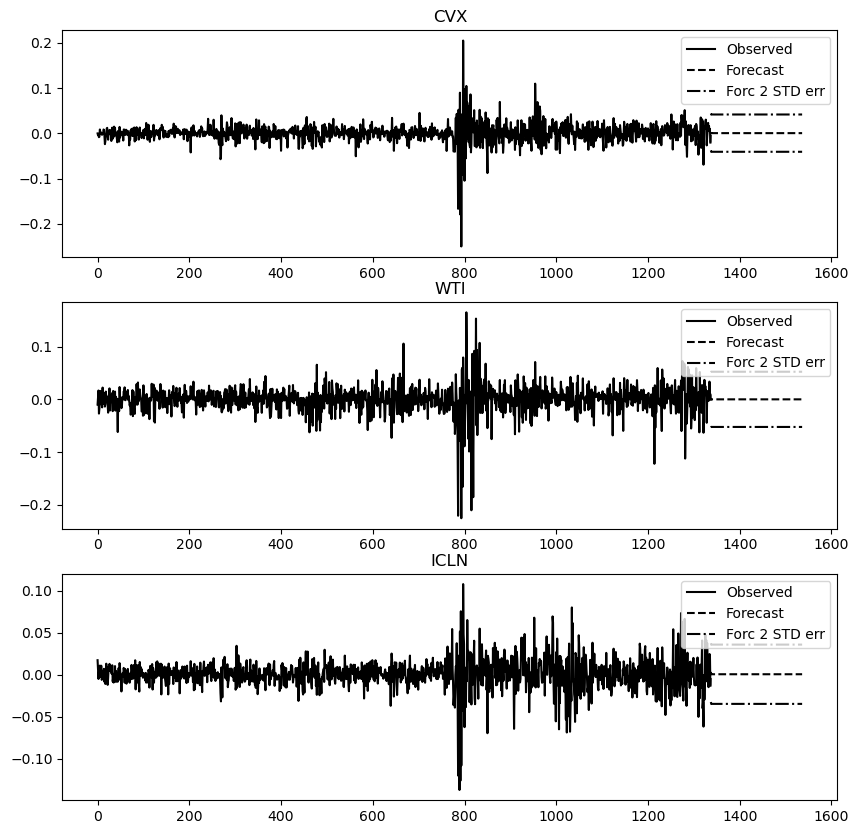

In [37]:
results.plot_forecast(200)
plt.show()

In [38]:
fevd = results.fevd(10)
fevd.summary()

FEVD for CVX
          CVX       WTI      ICLN
0    1.000000  0.000000  0.000000
1    0.999196  0.000493  0.000311
2    0.999190  0.000498  0.000312
3    0.999189  0.000498  0.000312
4    0.999189  0.000498  0.000312
5    0.999189  0.000498  0.000312
6    0.999189  0.000498  0.000312
7    0.999189  0.000498  0.000312
8    0.999189  0.000498  0.000312
9    0.999189  0.000498  0.000312

FEVD for WTI
          CVX       WTI      ICLN
0    0.277900  0.722100  0.000000
1    0.279003  0.720979  0.000018
2    0.279022  0.720959  0.000019
3    0.279022  0.720958  0.000019
4    0.279022  0.720958  0.000019
5    0.279022  0.720958  0.000019
6    0.279022  0.720958  0.000019
7    0.279022  0.720958  0.000019
8    0.279022  0.720958  0.000019
9    0.279022  0.720958  0.000019

FEVD for ICLN
          CVX       WTI      ICLN
0    0.231876  0.001314  0.766809
1    0.241450  0.001385  0.757165
2    0.241591  0.001401  0.757008
3    0.241593  0.001401  0.757006
4    0.241593  0.001401  0.757006
5    0

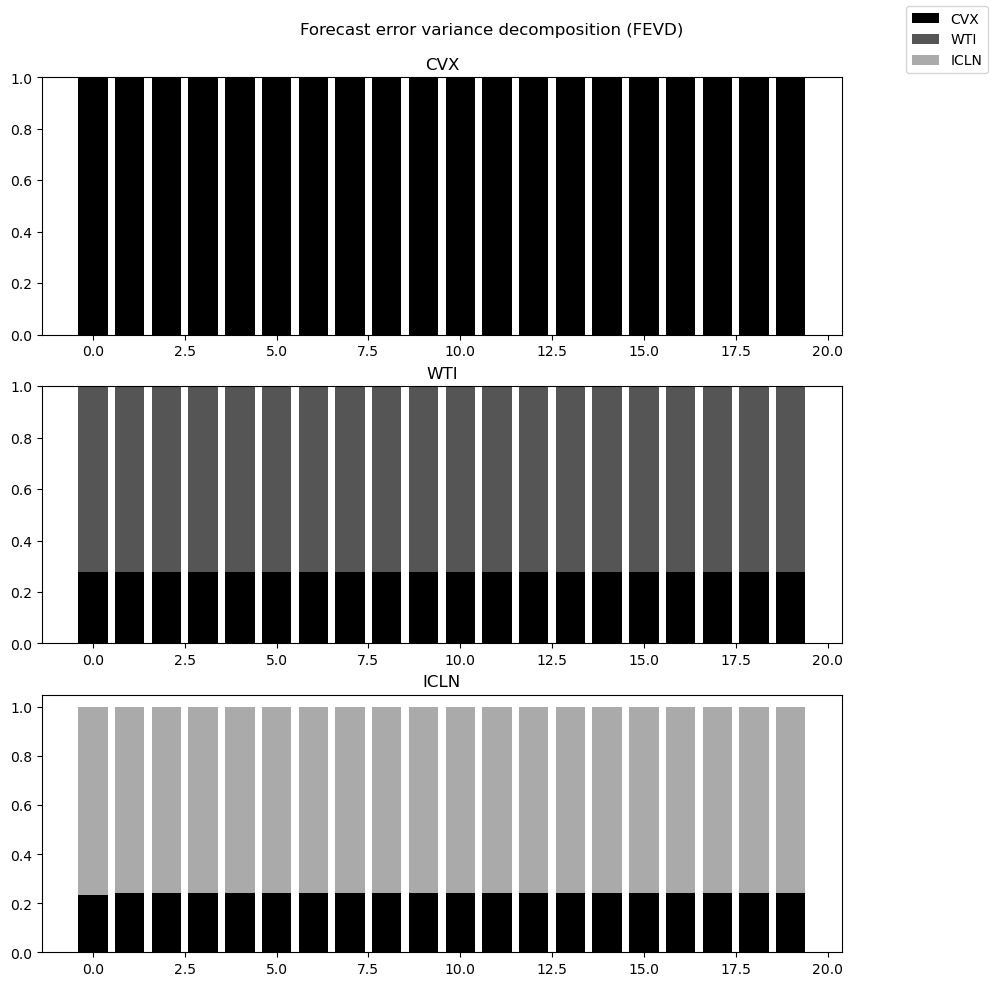

In [39]:
results.fevd(20).plot()
plt.show()

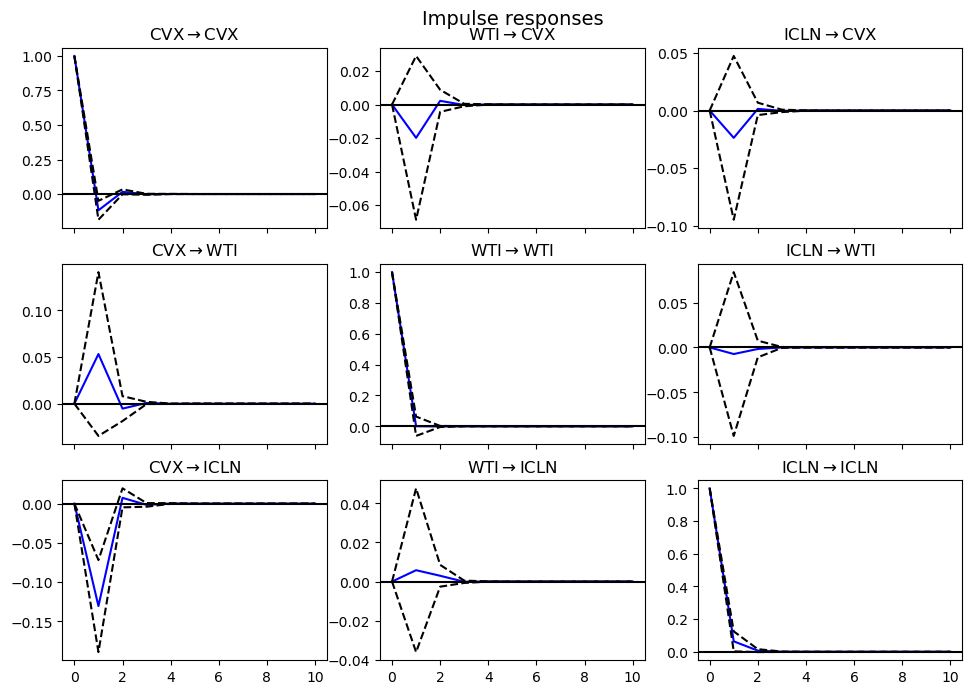

In [40]:
irf = results.irf(10)
irf.plot(orth=False, figsize=(10,7))
plt.show()

In [41]:
results.test_causality('CVX', ['WTI', 'ICLN'], kind='f').summary()

Test statistic,Critical value,p-value,df
0.5504,2.998,0.577,"(2, 3996)"


In [42]:
results.test_causality('WTI', 'CVX', kind='f').summary()

Test statistic,Critical value,p-value,df
1.412,3.844,0.235,"(1, 3996)"


## Bayesian VARs and the Minnesota prior

Both classical and Bayesian statistics provides us with tools for estimating the parameters of a VAR. For the frequentist (classical) approach, we can estimate the parameters of the model by a least squares regression, provided the stationarity conditions are met.

The classical estimation of VARs also relies on having a large amount of data, especially in models with many parameters. In this setting, where you have many parameters and few observations, least squares estimation becomes unfeasible. Bayesian estimation can provide a solution to this, as the prior distribution specification allows for more flexibility in model specification, and also allows for the use of shrinkage. See: https://kevinkotze.github.io/ts-9-bvar/

As a VAR usually has a large number of parameters, we resort to computational methods for Bayesian estimation. The Gibbs sampler is a very commonly used Bayesian computation routine where sampling is based on the conditional distributions of the posteriors, which makes it much easier than sampling from the joint distribution of parameters in models with many parameters. In a Gibbs sampling routine, we sample each parameter at a time while conditioning on all of the others. For example, in case we have three parameters, a Gibbs sampler would draw samples from

1. $P(\theta_1 | \theta_2, \theta_3)$

2. $P(\theta_2 | \theta_1, \theta_3)$

3. $P(\theta_3 | \theta_2, \theta_3)$

successively until we have enough draws to estimate the posterior distribution of the parameters. This is quite easy to implement if we have conjugate posteriors for all of the parameters.

Whenever the closed form posterior for a given parameter is not available, we can resort to Metropolis-Hastings (MH) algorithms. MH consists of sampling a value from a proposal distribution (usually a normal), calculating the target posterior density for the parameter at the proposed value, and compare it to the target density at the previous value accepting or rejecting the new proposed value. A Metropolis-Hastings algorithm can be written as

1. Specify a proposal distribution $Q(.)$, for example $N(\theta, \sigma_{MH})$, where $\sigma_{MH}$ is chosen so our sampler explores the posterior distribution well enough. It is important that the $Q$ distribution is symmetric, that is, for mean values $\theta$ and $\theta^*$ we have $Q(\theta^* | \theta) = Q(\theta | \theta^*)$, and the normal distribution satisfies this.

2. Sample a proposed value $\theta^*$ from $Q(\theta^*)$ and calculate the ratio $\alpha = \frac{f(\theta^*)}{f(\theta)}$, where $f(.)$ is the target distribution we want to sample from and $\theta$ is the previous value. 

3. Sample $u \sim U(0,1)$ and accept $\theta^*$ if $\alpha > u$, reject otherwise.

4. In case $\theta^*$ is accepted, it becomes the new $\theta$ and the algorithm is repeated until we get enough draws from the target posterior distribution.

Now that we know a few ways we can sample from posteriors, we turn our attention into how to specify priors. Conjugate priors are advantageous, as it allows us to write Gibbs samplers in a simple fashion. It may also be desirable to specify shrinkage priors, turning our inference more robust to extreme observations. 

In the case of the Bayesian VARs (BVARs), the Minnesota prior is perhaps the most famous prior distribution. It is a shrinkage prior, allowing us to control the strength of the shrinkage effect (the "tightness") through the hyperparameters. The Minnesota prior incorporates the prior belief that the variables follow a random walk process, which is a reasonable starting point given the empirical evidence that many macroeconomic time series behave like unit root processes (http://hedibert.org/wp-content/uploads/2015/03/nelson-plosser-1982.pdf). 

Suppose we have a bivariate VAR(1)

$y_{1,t} = c_1 + \phi_{11} y_{1,t-1} + \phi_{12} y_{2,t-1} + \varepsilon_{1,t}$,

$y_{2,t} = c_2 + \phi_{21} y_{1,t-1} + \phi_{22} y_{2,t-1} + \varepsilon_{2,t}$,

and our parameters are the intercepts and coefficients $\Theta = (c_1,\phi_{11},\phi_{12},c_2,\phi_{21},\phi_{22})$, plus the covariance matrix for the error terms, $\Sigma$.

The variables $y_{1,t}$ and $y_{2,t}$ behaving like random walks would imply that $c_1$,$c_2$,$\phi_{12}$ and $\phi_{21}$ are all equal to zero, and $\phi_{11}$ and $\phi_{22}$ equal to 1. The hyperparameters of the prior mean for the VAR intercepts and coefficients under the Minnesota prior are chosen to reflect this belief.

As for the prior variance, the Minnesota prior allows us to control the tightness around the prior mean, that is, the size of the shrinkage effect. In our example, we can write the Minnesota prior as

$\Theta = (c_1,\phi_{11},\phi_{12},c_2,\phi_{21},\phi_{22})$,

$p(\Theta) \sim N(\bar{\theta}, H)$,

$\bar{\theta} = [0,1,0,0,0,1]$,

$H = \operatorname{diag} \bigg( (\sigma_1 \lambda_c)^2, \lambda_1^2, \big(\frac{\sigma_1 \lambda_1 \lambda_2}{\sigma_2}\big)^2, (\sigma_2 \lambda_c)^2,  \big(\frac{\sigma_2 \lambda_1 \lambda_2}{\sigma_1}\big)^2, \lambda_1^2 \bigg) $,

where index $i$ refers to the equation (and dependent variable within that equation) and index $j$ to the independent variable, $\sigma_i$ and $\sigma_j$ to the variances of AR regression error terms estimated via OLS, and $\lambda_1$, $\lambda_2$ and $\lambda_c$ refer to the tightness hyperparameters for lags of the dependent variables, independent variables and constant terms. A more thorough explanation, together with examples for higher order VARs can be found at https://www.bankofengland.co.uk/-/media/boe/files/ccbs/resources/applied-bayesian-econometrics-for-central-bankers-updated-2017.pdf

As for $\Sigma$, the covariance matrix for the error terms, we can give it a standard conjugate prior, such as an inverse Wishart, for example.

Here we implement a Gibbs sampling routine for a Bayesian VAR heavily inspired from section 2.1 of chapter 2 of https://www.bankofengland.co.uk/-/media/boe/files/ccbs/resources/applied-bayesian-econometrics-for-central-bankers-updated-2017.pdf

In [43]:
np.random.seed(1)

bvar_data = pd.DataFrame([cvx_diff,wti_diff]).T.dropna()
Y = bvar_data.values
X = np.insert(bvar_data[:-1].values, 0, [0,0], axis=0)
X = np.insert(X.T, 0, np.ones(len(X)), axis=0).T

# hyperparameters

lamb_c = 1e2
lamb_1 = 0.2
lamb_2 = 0.5

model = sm.tsa.VAR(bvar_data)
results = model.fit(1)
Sigma = results.sigma_u

sigma_1 = np.sqrt(Sigma.values[0][0])
sigma_2 = np.sqrt(Sigma.values[1][1])

theta_bar = np.array([0,1,0,0,0,1])
H = np.diag([(sigma_1 * lamb_c)**2, (lamb_1)**2, ((sigma_1*lamb_1*lamb_2)/sigma_2)**2, (sigma_2 * lamb_c)**2, ((sigma_2*lamb_1*lamb_2)/sigma_1)**2, (lamb_1)**2])

theta_hat = (np.linalg.inv(X.T @ X) @ (X.T @ Y)).flatten()

S_bar = np.eye(2)
alpha_df = 3

# initialize objects to store sampled values
n_samples = 1000
theta_sampled = np.empty([n_samples, 6])
Sigma_sampled = np.empty([n_samples, 2, 2])

# sampler
for i in range(0, n_samples):
    # step 1: sample coefficients conditional on covariance matrix Sigma
    M_star = np.linalg.inv(np.linalg.inv(H) + np.kron(np.linalg.inv(Sigma) , X.T @ X)) @ (np.linalg.inv(H) @ theta_bar + np.kron(np.linalg.inv(Sigma) , X.T @ X) @ theta_hat)
    V_star = np.linalg.inv(np.linalg.inv(H) + np.kron(np.linalg.inv(Sigma) , X.T @ X))
    theta = np.random.multivariate_normal(M_star, V_star)
    theta_sampled[i] = theta
    
    # step 2: sample covariance matrix Sigma
    theta_matrix = theta.reshape(2,3).T
    Sigma_bar = S_bar + (Y - (X @ theta_matrix)).T @ (Y - (X @ theta_matrix))
    Sigma = st.invwishart.rvs(alpha_df+len(Y), Sigma_bar)
    Sigma_sampled[i] = Sigma

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


As Bayesian inference gives us the whole posterior distribution of parameters given the data, we can compare posterior moments, e.g. medians, to classical estimates

In [44]:
theta_median = np.median(theta_sampled, axis=0)
theta_median.round(3)

array([ 0.   ,  0.038, -0.113,  0.05 , -0.06 ,  0.118])

In [45]:
Sigma_median = np.median(Sigma_sampled,axis=0)
Sigma_median

array([[0.00118596, 0.00028484],
       [0.00028484, 0.00396965]])

In [46]:
model_classical = sm.tsa.VAR(bvar_data)
results_classical = model_classical.fit(1)
results_classical.summary()

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Jan, 2024
Time:                     19:29:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.2896
Nobs:                     1336.00    HQIC:                  -15.3042
Log likelihood:           6443.64    FPE:                2.23705e-07
AIC:                     -15.3129    Det(Omega_mle):     2.22703e-07
--------------------------------------------------------------------
Results for equation CVX
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000397         0.000569            0.698           0.485
L1.CVX        -0.127391         0.031666           -4.023           0.000
L1.WTI        -0.020428         0.024890           -0.821           0.412

Results for equ

We can see that the Minnesota prior pulls our coefficient estimates closer to the prior assumption that the series follow random walks. The size of this effect can be controlled, however, with the tightness hyperparameters.

## Statistical cointegration

We talked about, although many variables are nonstationary and behave like unit root processes in practice, the VAR requires that the variables be stationary. There is another way we can create a statistical model for two nonstationary time series, the vector error correction models, or VECM. These are based on a statistical property known as cointegration, that is present when, for two $I(p)$ series, there is a linear combination of both series that is $I(p-k)$. In practice, this mostly happens when we have two $I(1)$ series, but there is a linear combination of both that is $I(0)$.

The Johansen test is a statistical test for the presence of cointegration among time series. In the case a cointegration relationship is present, we can fit a VECM to the series. Suppose we write the cointegration relationship between $y_{1,t}$ and $y_{2,t}$ as

$y_{1,t} = \alpha + \beta y_{2,t}$,

the we can use this to specify a VECM. A VECM for a bivariate VAR(1) can be written as

$\Delta y_{1,t} = c_1 + \phi_{11} \Delta y_{1,t-1} + \phi_{12} \Delta y_{2,t-1} + \lambda_1 (\alpha + \beta y_{2,t} - y_{1,t}) + \varepsilon_{1,t}$,

$\Delta y_{2,t} = c_2 + \phi_{21} \Delta y_{1,t-1} + \phi_{22} \Delta y_{2,t-1} + \lambda_2 (\alpha + \beta y_{2,t} - y_{1,t}) + \varepsilon_{2,t}$,

or, alternatively, in matrix form

$\Delta \textbf{y}_t = \textbf{c} + A \Delta \textbf{y}_{t-1} + \Lambda \textbf{y}_{t-1} + \boldsymbol{\varepsilon}_t$,

with $\Lambda = (A - I)$.

We can try fitting a VECM to the log-prices of CVX and WTI and obtain model forecasts

In [47]:
vecm_data = pd.concat([cvx.apply(np.log),wti.apply(np.log)], axis=1).dropna().asfreq("D", method="bfill")
sm.tsa.var.vecm.select_coint_rank(vecm_data, det_order=1, k_ar_diff=1).summary()

r_0,r_1,test statistic,critical value
0,2,24.33,18.40
1,2,1.052,3.841


The Johansen test rejected the hypothesis that we have 0 cointegration relationships, but failed to reject the hypothesis that we have 1 cointegration relationship.

In [48]:
model = sm.tsa.VECM(vecm_data)
results = model.fit()
results.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.CVX,-0.1170,0.026,-4.494,0.000,-0.168,-0.066
L1.WTI,0.0148,0.021,0.723,0.470,-0.025,0.055
,coef,std err,z,P>|z|,[0.025,0.975]
L1.CVX,-0.0040,0.033,-0.121,0.904,-0.069,0.061
L1.WTI,0.0290,0.026,1.107,0.268,-0.022,0.080
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0010,0.001,1.662,0.096,-0.000,0.002
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0013,0.001,1.761,0.078,-0.000,0.003
,coef,std err,z,P>|z|,[0.025,0.975]


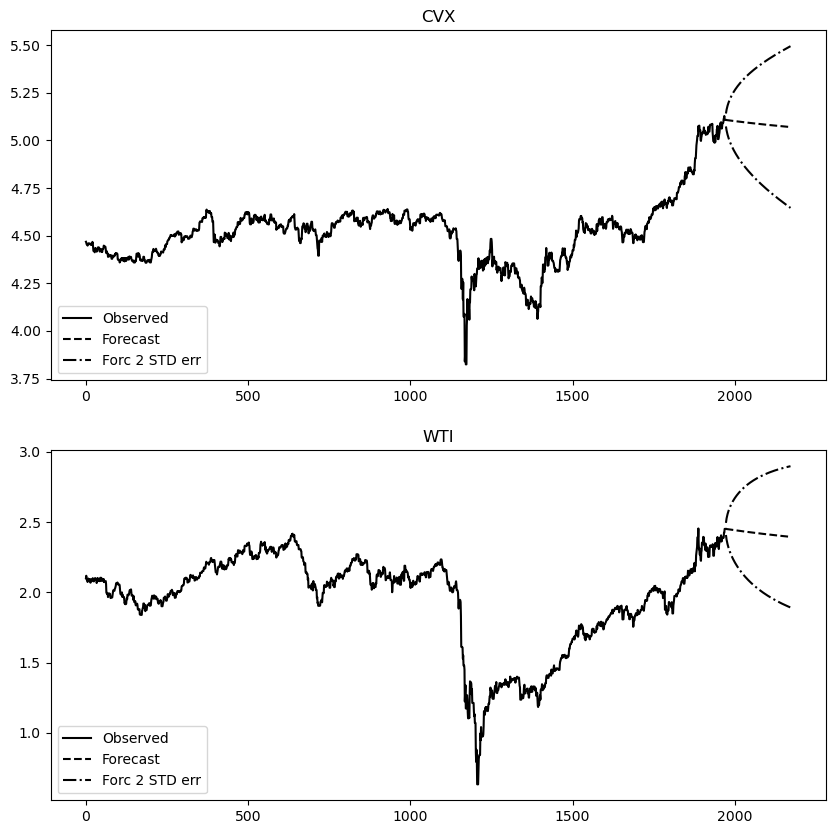

In [49]:
results.plot_forecast(200)
plt.show()

## State space models

Another type of multivariate time series models are state space models. This type of model treats one of the series as unobserved, or latent. A very common example of the state space approach is when we presume the observed time series has noise in it, and we want to filter out the noise to discover the "true state" of the other variable, presumed to be latent. Practical examples of this include signal processing, or realized versus potential GDP in macroeconomics.

For example, if we have the observed time series $y_t$ that is a noisy observation of the latent series $x_t$ following a random walk, a state space model could look like

$y_t = x_t + \varepsilon_t$,

$x_t = x_{t-1} + \eta_t$,

with $\varepsilon_t \sim N(0, \sigma^2_y)$, $\eta_t \sim N(0, \sigma^2_x)$ and some initial value $x_0$. As $x_t$ is not observed, we can model it as the random variable $x_t \sim N(x_{t-1}, \sigma^2_x)$, which means that the values $x_1, x_2, \ldots, x_t$ are in practice treated as parameters to be estimated. It is possible for the state variable to follow processes other than the random walk, such as an autoregressive process, for example.

The statsmodels library allows us to specify many different types of state space models. We can try fitting an unobserved components model, more specifically a local level model for the CPI inflation series

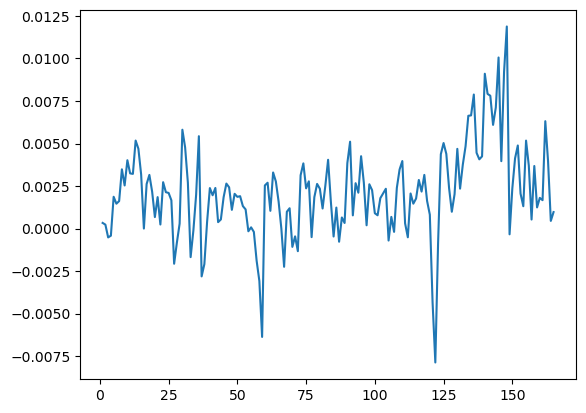

In [50]:
cpi_infl = pd.read_csv("https://api.db.nomics.world/v22/series/BLS/cu/CUSR0000SA0.csv", index_col = 0)['2010-01-01':].pct_change()
plt.plot(cpi_infl.values)

In [51]:
model_ll = sm.tsa.UnobservedComponents(cpi_infl, 'local level')
results_ll = model_ll.fit()
results_ll.summary()

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                             Unobserved Components Results                                                              
========================================================================================================================================================
Dep. Variable:     U.S. city average – Current – All items – Monthly – Seasonally Adjusted (BLS/cu/CUSR0000SA0)   No. Observations:                  166
Model:                                                                                              local level   Log Likelihood                 752.403
Date:                                                                                          Mon, 01 Jan 2024   AIC                          -1500.805
Time:                                                                                                  19:29:44   BIC                          -1494.593
Sample:                                                                                              02-01-2010   HQIC                         -1498.284
                                                                                                   - 11-01-2023                                         
Covariance Type:                                                                                            opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  3.823e-06   3.55e-07     10.778      0.000    3.13e-06    4.52e-06
sigma2.level      4.996e-07   1.61e-07      3.102      0.002    1.84e-07    8.15e-07
===================================================================================
Ljung-Box (L1) (Q):                   8.96   Jarque-Bera (JB):                24.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

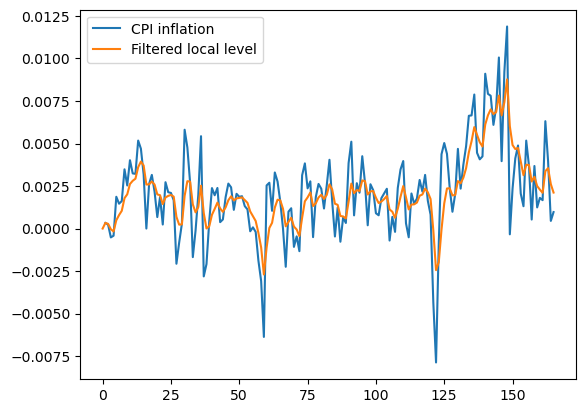

In [52]:
plt.plot(cpi_infl.values, label= "CPI inflation")
plt.plot(results_ll.level.filtered, label="Filtered local level")
plt.legend()

The Kalman filter is one of the benchmark frameworks for estimating unknown latent variables from the observation of a noisy process. It can be written as an algorithm where we start with prior knowledge about the latent variable respresented as a probability distribution, and then update our knowledge with each measurement. Conceptually, the Kalman filter can be seen as Bayesian, although, as the prior and measurement (likelihood) distributions are assumed to be normal, we can get closed conjugate forms for the posteriors, and therefore Bayesian computation is not needed.

Suppose we have the state space model in the form

$\mathbf{y}_t = G \mathbf{x}_t + \boldsymbol{\varepsilon}_t$, $\boldsymbol{\varepsilon}_t \sim N(0, R)$,

$\mathbf{x}_t = F \mathbf{x}_{t-1} + \boldsymbol{\eta}_t$, $\boldsymbol{\eta}_t \sim N(0,Q)$,

where the first equation is the measurement (observation) equation, and the second is the transition (state) equation. The matrices $G$ and $F$ are responsible for the  dynamics of the measurement and transition equations. If we want to apply the Kalman filter to this model, we need to start out with some prior knowledge about $\mathbf{x}_0$, summarized in the form of a normal distribution

$P(\mathbf{x}_0) \sim N(\hat{x}_0, \Sigma_0) $,

the following values for $\mathbf{x}_t$ given a past value have distribution $N(F \mathbf{x}_{t-1}, Q)$ and the measurement $\mathbf{y}_t$ given $\mathbf{x}_t$ has distribution $N(G \mathbf{x}_t, R)$, we can obtain the posterior distribution for the states $\mathbf{x}_t$ given the observations $\mathbf{y}_t$

$\mathbf{x}_t|\mathbf{y}_t \sim N(F \hat{\mathbf{x}} + F\Sigma G' (G\Sigma G' + R)^{-1} (\mathbf{y} - G \hat{\mathbf{x}}), F \Sigma F' - F\Sigma G' (G\Sigma G' + R)^{-1} G \Sigma F' + Q)$,

where $\hat{\mathbf{x}}$ is the prior mean and $\Sigma$ is the prior covariance, set to $\hat{\mathbf{x}}_0, \Sigma_0$ at the first step and updated in succession (the old posterior becomes the new prior). 

The matrix $F\Sigma G' (G\Sigma G' + R)^{-1}$ is known as the Kalman gain. Intuitively, this measures how much information about the unobserved state we gain from the observed variable.

The derivations for the Kalman filter can be done in a Bayesian framework, as we did here, but, as the Kalman filter is linear and Gaussian, it is also possible to derive it in a classical, linear regression framework. For a thorough derivation, see: https://python.quantecon.org/kalman.html

The statsmodels unobserved components models already make use of Kalman filtering/smoothing routines

It turns out that the Bayesian approaches for state space modeling and the Kalman filter, are, together with feature selection, causal inference and model comparison, part of a novel modeling approach known as Bayesian structural time series (BSTS). 

BSTS can be seen as a Bayesian alternative to the Box-Jenkins (ARIMA) approach, allowing for more flexibility in model specification. It allows for latent (state) variables with many different possible specifications, as in the state space approach. It can also incorporate exogenous regressors (as it was the case for ARIMA), with built-in feature selection methods such as spike-and-slab priors. Additional information may also be incorporate through the prior distribution of the parameters, and different models can be compared with techniques such as Bayesian model averaging. The BSTS models are generally estimated via MCMC algorithms.

We can propose a BSTS for the stock returns of Chevron, an oil company, with WTI crude oil and S&P 500 returns as regressors (exogeous variables) plus a state space specification for stochastic volatility. This model can then be fitted with PyMC

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


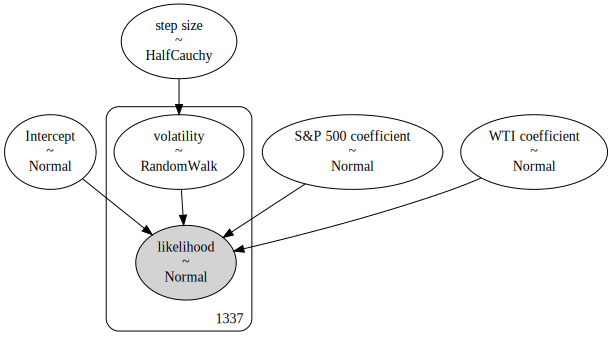

In [54]:
sp = yf.Ticker("^GSPC").history(start = start_date, end = end_date)["Close"].rename("S&P 500")
sp.index = sp.index.tz_localize(None)
sp_diff = np.log(sp).diff().dropna()

returns_df = pd.concat([cvx_diff, wti_diff, sp_diff], axis=1).dropna()

with pm.Model() as bsts_model:
    alpha = pm.Normal("Intercept", mu=0, sigma=1)
    beta_wti = pm.Normal("WTI coefficient", mu=0, sigma=1)
    beta_sp = pm.Normal("S&P 500 coefficient", mu=0, sigma=1)

    y_mean = alpha + beta_wti * returns_df["WTI"].values + beta_sp * returns_df['S&P 500'].values

    step_size = pm.HalfCauchy('step size', beta = 1)
    vol = pm.GaussianRandomWalk("volatility", sigma=step_size, shape = len(returns_df))
    
    y = pm.Normal("likelihood", mu=y_mean, sigma=pm.math.exp(vol), observed=returns_df['CVX'].values)
pm.model_to_graphviz(bsts_model)

In [55]:
with bsts_model:
    trace_bsts = pm.sample(2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, WTI coefficient, S&P 500 coefficient, step size, volatility]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 435 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'WTI coefficient'}>,
        <Axes: title={'center': 'WTI coefficient'}>],
       [<Axes: title={'center': 'S&P 500 coefficient'}>,
        <Axes: title={'center': 'S&P 500 coefficient'}>],
       [<Axes: title={'center': 'step size'}>,
        <Axes: title={'center': 'step size'}>]], dtype=object)

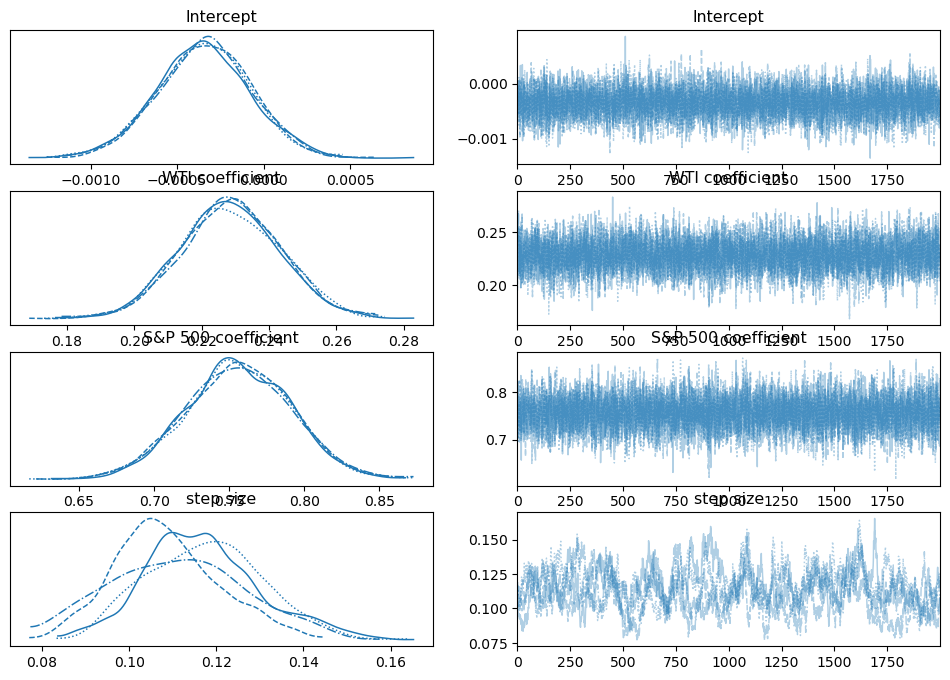

In [56]:
az.plot_trace(trace_bsts, var_names=['~volatility'])

In [57]:
az.summary(trace_bsts, var_names=["~volatility"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.000,0.000,-0.001,0.000,0.000,0.000,8756.0,5253.0,1.00
WTI coefficient,0.229,0.015,0.200,0.255,0.000,0.000,7344.0,6655.0,1.00
S&P 500 coefficient,0.756,0.035,0.690,0.822,0.000,0.000,7775.0,6149.0,1.00
step size,0.114,0.014,0.087,0.141,0.001,0.001,104.0,189.0,1.05


Text(0.5, 1.0, 'Median posterior volatility')

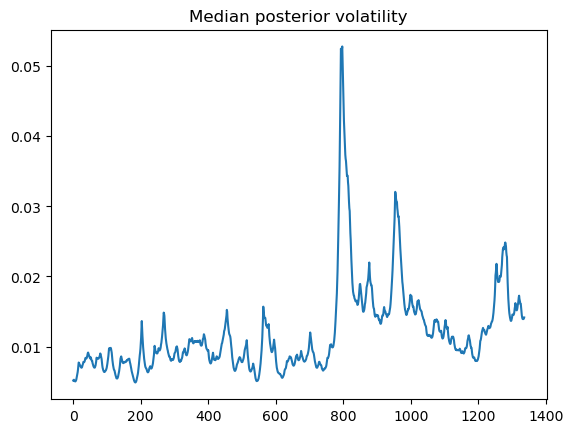

In [58]:
vol_median = np.median(trace_bsts.posterior['volatility'].values, axis=(0,1)) # median across chains and draws 
plt.plot(np.exp(vol_median))
plt.title("Median posterior volatility")

## Additional references for this section

Hamilton, J. D. (2020). Time Series Analysis. Chapter 3 present ARMA models, Chapter 11 introduce vector autoregressions, Chapter 13 presents state space models and the Kalman filter, and Chapter 15 presents nonstationary time series.

Andrew Blake and Haroon Mumtaz (2017). Applied Bayesian econometrics for central bankers. A great introduction to Bayesian time series econometrics, containing topics such as priors, samplers, vector autoregressions, state space models, among others.

Lütkepohl, H. (2006). New Introduction to Multiple Time Series Analysis. A more thorough overview of vector autoregressions and related topics, such as estimation and model checking, cointegration, volatility modeling and structural VARs.